In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('x_imputed_less_response.csv')
y = pd.read_csv('response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

2024-12-24 03:50:04.379051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 03:50:04.403031: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-24 03:50:04.685058: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-24 03:50:04.912787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735012205.095692    2154 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735012205.14

In [2]:
X_scaled

,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2016,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2017,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2018,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2019,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2020,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2021,"airpollutant:_1,3-butadiene_ug_m^3_epa2018",total_population_16yr_and_over_for_work_commute_acs2017_21,total_population_with_daily_commute_less_than_15min_acs2017_21,total_population_with_daily_commute_between_15_60min_acs2017_21,...,"asian_ischemic_heart_disease_death_rate_per_100,000_cdc_ehtracking_2019_2019","asian_ischemic_heart_disease_death_rate_per_100,000_cdc_ehtracking_2020_2020","asian_ischemic_heart_disease_death_rate_per_100,000_cdc_ehtracking_2021_2021","api_single_race_stroke_death_rate_per_100,000_cdc_ehtracking_2018_2018","api_stroke_death_rate_per_100,000_cdc_ehtracking_2018_2018",percent_of_farmers_market_accept_snap_usda_2018_2018,airpollutant:_acetaldehyde_ug_m^3_epa2017_2018,airpollutant:_benzene_ug_m^3_epa2017_2018,airpollutant:_carbon_tetrachloride_ug_m^3_epa2017_2018,airpollutant:_formaldehyde_ug_m^3_epa2017_2018
0,-0.448598,-0.449336,-0.448326,-0.453732,-0.433578,-0.450154,0.507467,-0.126440,-0.184230,-0.108269,...,-0.199805,-0.236288,-0.294691,-0.484167,-0.484167,-0.565024,2.053383,-0.069159,0.299727,1.816241
1,1.911845,1.827373,1.698797,2.016260,1.918573,1.660619,0.507467,0.369824,0.501062,0.358277,...,-0.199805,-0.236288,1.243431,2.214199,2.214199,-0.565024,1.076609,-0.268959,0.299727,1.024750
2,-0.448598,-0.449336,-0.448326,-0.453732,-0.433578,-0.450154,1.891545,-0.247088,-0.288269,-0.244702,...,-0.199805,-0.236288,-0.294691,-0.484167,-0.484167,1.008271,2.038583,-0.169059,0.245885,1.744287
3,-0.448598,-0.449336,-0.448326,-0.453732,-0.433578,-0.450154,0.507467,-0.252077,-0.348340,-0.234419,...,-0.199805,-0.236288,-0.294691,3.844673,3.844673,-0.565024,2.408573,-0.119109,0.299727,2.092063
4,-0.448598,-0.449336,-0.448326,-0.453732,-0.433578,-0.450154,0.507467,-0.140478,-0.234873,-0.137579,...,-0.199805,-0.236288,-0.294691,-0.484167,-0.484167,-0.565024,1.343002,0.030741,0.245885,1.468464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,-0.448598,-0.449336,-0.448326,-0.453732,-0.433578,-0.450154,-0.876611,-0.306583,-0.413691,-0.285672,...,-0.199805,-0.236288,-0.294691,-0.484167,-0.484167,-0.565024,-2.253303,-1.917308,-4.438330,-2.417035
3288,-0.448598,-0.449336,-0.448326,-0.453732,-0.433578,-0.450154,-0.876611,-0.306583,-0.413691,-0.285672,...,-0.199805,-0.236288,-0.294691,-0.484167,-0.484167,-0.565024,-2.253303,-1.917308,-4.438330,-2.417035
3289,-0.448598,-0.449336,-0.448326,-0.453732,-0.433578,-0.450154,-0.876611,-0.306583,-0.413691,-0.285672,...,-0.199805,-0.236288,-0.294691,-0.484167,-0.484167,-0.565024,-2.253303,-1.917308,-4.438330,-2.417035
3290,-0.448598,-0.449336,-0.448326,-0.453732,-0.433578,-0.450154,-0.876611,-0.306583,-0.413691,-0.285672,...,-0.199805,-0.236288,-0.294691,-0.484167,-0.484167,-0.565024,-2.253303,-1.917308,-4.438330,-2.417035


In [8]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


/home/tonyluo/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

Trial 9 Complete [00h 00m 25s]
val_mae: nan

Best val_mae So Far: nan
Total elapsed time: 00h 03m 43s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
192               |128               |units_0
0.3               |0.4               |dropout_0
192               |128               |units_1
0.4               |0.4               |dropout_1
0.00023572        |0.00076926        |learning_rate
256               |None              |units_2
0.4               |None              |dropout_2

Epoch 1/50


/home/tonyluo/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 58893.2695 - mae: nan - val_loss: 52826.9219 - val_mae: nan
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48503.8359 - mae: nan - val_loss: 31387.1602 - val_mae: nan
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23022.3320 - mae: nan - val_loss: 10637.8574 - val_mae: nan
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8647.5791 - mae: nan - val_loss: 4259.4434 - val_mae: nan
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4505.4053 - mae: nan - val_loss: 2027.4293 - val_mae: nan
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2949.1743 - mae: nan - val_loss: 1514.4559 - val_mae: nan
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2312.0042 - mae: nan - val_loss: 1363.6677 - val_mae: nan
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2199.5493 - mae: nan - val_loss: 1279.0712 - val_mae: nan
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1943.9980 - mae: n

/home/tonyluo/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 59781.7812 - mae: nan - val_loss: 55591.0352 - val_mae: nan
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51556.9102 - mae: nan - val_loss: 38872.5195 - val_mae: nan
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30737.8984 - mae: nan - val_loss: 13172.5068 - val_mae: nan
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10593.7871 - mae: nan - val_loss: 4893.5488 - val_mae: nan
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4786.9072 - mae: nan - val_loss: 2215.3240 - val_mae: nan
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2928.6179 - mae: nan - val_loss: 1539.3807 - val_mae: nan
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2709.9187 - mae: nan - val_loss: 1364.8273 - val_mae: nan
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2243.2344 - mae: nan - val_loss: 1280.7864 - val_mae: nan
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2133.6018 - mae: 

/home/tonyluo/.local/lib/python3.9/site-packages/keras_tuner/src/engine/metrics_tracking.py:111: RuntimeWarning: All-NaN axis encountered
  np.nanmin(values) if self.direction == "min" else np.nanmax(values)


RuntimeError: Number of consecutive failures exceeded the limit of 10.


In [176]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


In [177]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(629, 439)


In [178]:
shap_values = np.squeeze(shap_values)  

import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
                                               feature  importance
418  amount_of_snap_redemption_per_snap_authorized_...    5.672078
61       per_capita_income_in_the_past_year_acs2016_20    4.878961
34   healthstatus_percent_pop_mental_health_not_goo...    4.708378
419       amount_of_snap_benefits_per_capita_usda_2017    4.333987
182                 community_resilience_score_nri2020    4.064500
..                                                 ...         ...
167  population_18yrs_and_under_without_health_insu...    0.121134
422                number_of_fdpir_available_usda_2015    0.108184
303  riverine_flooding_expected_annual_loss_agricul...    0.104667
358  api_within_a_mile_of_park_facilities_2020_cdc_...    0.088985
415  nhpi_population_with_low_access_to_store_usda_...    0.028315

[439 rows x 2 columns]


/home/tonyluo/.local/lib/python3.9/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


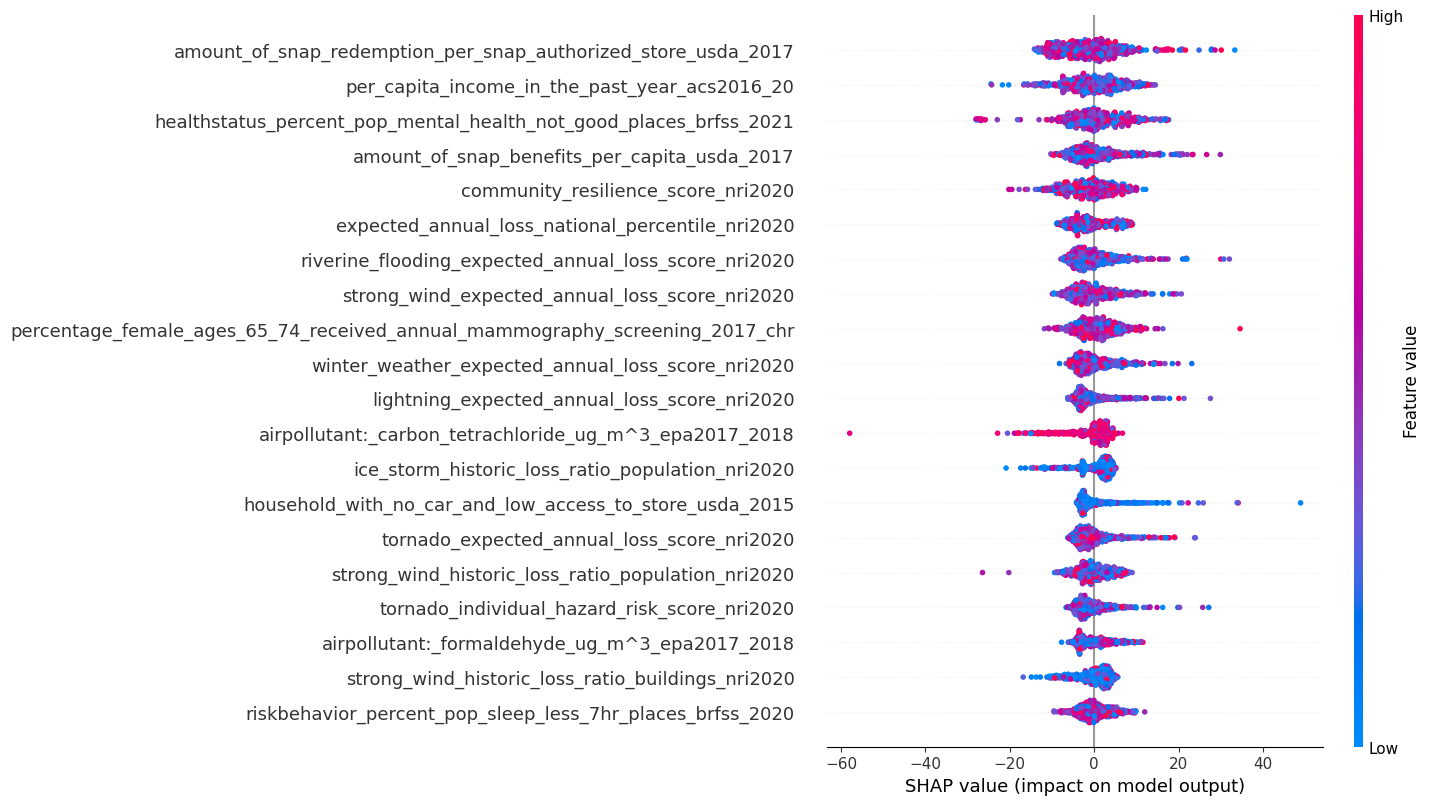

In [179]:
import shap
shap.summary_plot(shap_values, X_test, max_display=20)  # Adjust max_display as needed
